In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [37]:
# Find the earliest measurement date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [38]:
# How many measurement dates does the data in this table cover?
# This will tell me the total number of rows of measurement data (but not the unique dates those observations were taken)
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [39]:
# Calculate the date 1 year prior to the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [40]:
# Perform a query to retrieve the sum of the precipitation amount (across all stations) by date
# Sort the result by date
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

In [41]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Remove rows with NA values
# Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()

,precipitation_amount
measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


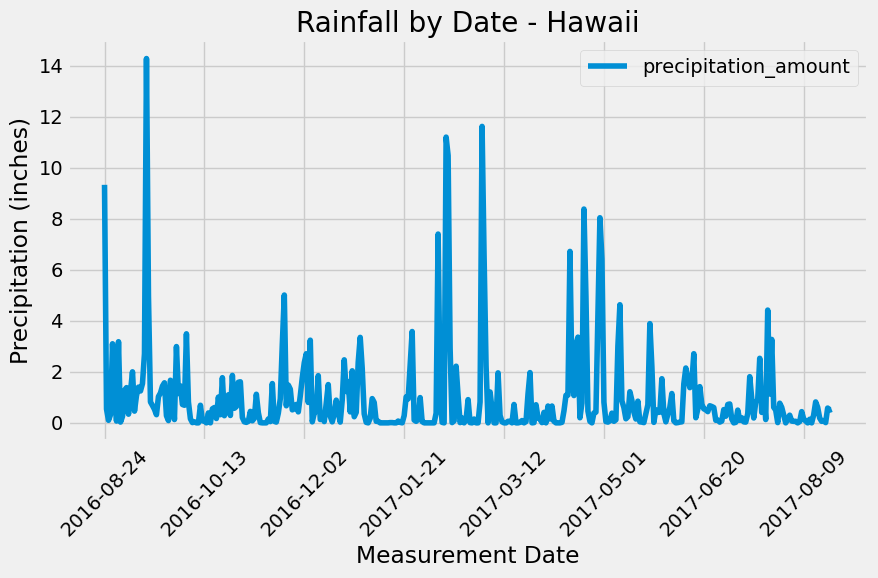

In [49]:
# Plot the results using the DataFrame plot method.

ax = precipitation_df.plot(rot=45, title = "Rainfall by Date - Hawaii", xlabel='Measurement Date', ylabel = "Precipitation (inches)", figsize=(9,6))
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
ax.figure.savefig('yearly_Precipitation_Hawaii.png', bbox_inches='tight')

# Exploratory Station Analysis

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [44]:
# What are the most active stations? (i.e. what stations have the most measurements)?
# This query lists the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


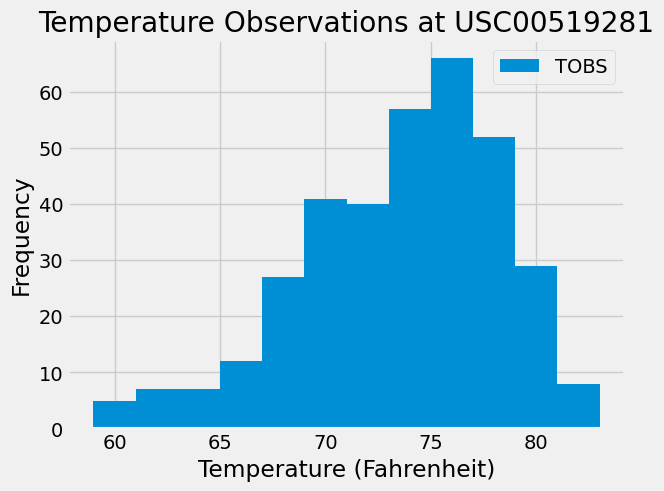

In [50]:
# Create a histogram to visualize the temperature observations from Station USC00519281 

plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Yearly_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [48]:
# Close Session
session.close()